In [14]:
import time
import warnings
from bisect import bisect_left

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

In [15]:
def frobenius_norm(matrix):
    """
    The Frobenius Norm of matrix A is 
        ||𝐴|| = \sqrt{\sum_{i=1}^n \sum_{j=1}^n a_{ij}^2}.
    """
    return np.sqrt(np.square(matrix).sum())

In [16]:
def run_time(f, *args, **kwargs):
    """Records the run time of a callable f."""
    t1 = time.time()
    result = f(*args, **kwargs)
    return time.time() - t1, result

# Problem 1

Use the stock returns in DailyReturn.csv for this problem. DailyReturn.csv contains returns for  
100 large US stocks and as well as the ETF, SPY which tracks the S&P500.  
Create a routine for calculating an exponentially weighted covariance matrix. If you have a  
package that calculates it for you, verify that it calculates the values you expect. This means  
you still have to implement it.  
Vary λ ∈ (0, 1). Use PCA and plot the cumulative variance explained by λ ∈ (0, 1) each eigenvalue for each λ chosen.  
What does this tell us about values of λ and the effect it has on the covariance matrix?  

In [17]:
def exponential_weights(lambda_, nlags):
    weights = np.array([(1-lambda_) * (lambda_**(lag-1)) for lag in range(1,nlags+1)])
    weights /= weights.sum() # normalized weights
    return weights


def cal_ewcov(data, lambda_):
    """
    Calculate the exponentially weighted covariance of a dataset matrix.
    Equation:
    
        \sigma_t^2 = (1 − \lambda) \sum_{i=1}^{\infty}{\lambda^{i-1} (x_{t-i} - \bar{x})^2}
    
    params:
        - data: The dataset has n observations(ordered from the most recent to the least recent ) 
                on m varaibles. Can be denoted as [[x1_t-1, x1_t-2, ...., x1_t-n],
                                                    ...,
                                                   [xm_t-1, xm_t-2, ...., xm_t-n]].
                The dataset should be an instance of np.matrix (but not np.array). 
        
        - lambda_: to put how much weight on t-1's forecast variance
    """
    
    dev = data - data.mean(axis=1) # deviation
    weights = exponential_weights(lambda_, data.shape[1])
    
    # apply the weights to the deviation
    cov = dev @ np.diag(weights) @ dev.T
    return cov


class PCA:
    """
    Apply PCA to a n*n covariance matrix sigma.
    """
    
    def __init__(self, sigma):
        eig_vals, eig_vecs = np.linalg.eigh(sigma)
       
        # only keep positive eigen values and vectors
        is_positive = eig_vals > 1e-8
        eig_vals = eig_vals[is_positive]# .astype('float') # eigen values can have very tiny imaginary parts  
        eig_vecs = eig_vecs[:, is_positive]# .astype('float')
        
        # sort the eigen values and eigen vectors in a descending order
        desc_ranking = np.argsort(eig_vals)[::-1]
        self._eig_vals = eig_vals[desc_ranking]
        self._eig_vecs = eig_vecs[:, desc_ranking]
        
        # calculate explained variance ratio (evr)
        self._evr = self._eig_vals / self._eig_vals.sum()
         
        # set the last value to 1 to eliminate rouding errors of floating point numbers
        self._cumulative_evr = self._evr.cumsum()
        self._cumulative_evr[-1] = 1
        
    @property
    def explained_variance(self):
        return self._eig_vals
    
    @property
    def explained_variance_ratio(self):
        return self._evr
    
    @property
    def cumulative_evr(self):
        return self._cumulative_evr
    
    @property
    def eig_vecs(self):
        return self._eig_vecs

In [18]:
# test for PCA
S = np.matrix([[1, 2, 3, 4],
               [4, 9, 6, 8],
               [7, 2, 9, 10]])

cov = np.cov(S)
pca = PCA(cov)
pca.explained_variance

from sklearn import decomposition
skl_pca = decomposition.PCA()
skl_pca.fit(S.T) # input need to be transposed
skl_pca.explained_variance_

(pca.explained_variance - skl_pca.explained_variance_).sum() < 1e-8

True

## 1.1 PCA on Exponentially Weighted Covariances

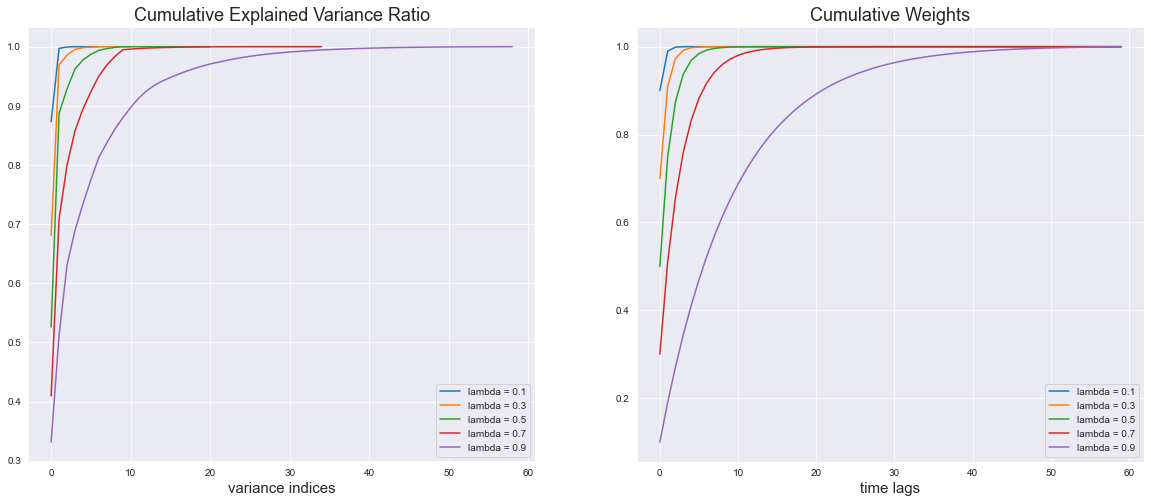

In [19]:
# import DailyReturn.csv in reversed the order to show recent data first, 
# drop the timestamp column, transpose it, then create a data matrix
daily_return = pd.read_csv("DailyReturn.csv").iloc[::-1, 1:].T
daily_return = np.matrix(daily_return)

lambdas = [0.1, 0.3, 0.5, 0.7, 0.9]
covs = [cal_ewcov(daily_return, lambda_) for lambda_ in lambdas]
pcas = [PCA(cov) for cov in covs]
eweights = [exponential_weights(lambda_, daily_return.shape[1]) for lambda_ in lambdas]


fig, axes = plt.subplots(1, 2, figsize=(20,8))

# plot cumulative evr on the left graph
for i in range(len(lambdas)):
    cumulative_evr = pcas[i].cumulative_evr 
    axes[0].plot(np.arange(cumulative_evr.shape[0]), cumulative_evr, label=f"lambda = {lambdas[i]}")
axes[0].set_xlabel('variance indices', fontsize=15)
axes[0].set_title("Cumulative Explained Variance Ratio", fontsize=18)
axes[0].legend(loc='best')

# plot cumulative weights on the right graph
for i in range(len(lambdas)):
    cum_eweight = eweights[i].cumsum()
    axes[1].plot(np.arange(cum_eweight.shape[0]), cum_eweight, label=f"lambda = {lambdas[i]}")
    
axes[1].set_xlabel('time lags', fontsize=15)
axes[1].set_title("Cumulative Weights", fontsize=18)
axes[1].legend(loc='best')
# fig.savefig("fig1.jpeg")

# Problem 2
Copy the chol_psd(), and near_psd() functions from the course repository –implement in your programming language of choice.   
These are core functions you will need throughout the remainder of the class.    
Implement Higham’s 2002 nearest psd correlation function.    
    
Generate a non-psd correlation matrix that is 500x500. You can use the code I used in class:  

```
n = 500  
sigma = fill(0.9, (n, n))  
for i in 1:n  
    sigma[i, i] = 1.0  
end  
sigma[1, 2] = 0.7357  
sigma[2, 1] = 0.7357  
```

Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD.Compare the results of both using the Frobenius Norm. Compare the run time between the two. How does the run time of each function compare as N increases?  
Based on the above, discuss the pros and cons of each method and when you would use each.There is no wrong answer here, I want you to think through this and tell me what you think.  

## 2.1 Cholesky Factorization

In [20]:
def chol_psd(sigma):
    """
    Apply Cholesky Factorization to matrix sigma.
    Sigma is expected to be PD or PSD. 
    """
    root = np.full(sigma.shape, 0.0, dtype='float64')

    # loop over columns
    n = root.shape[1]
    for j in range(n):

        # 1. the diagonal value
        # Ljj = sqrt(Ajj - (Lj1^2 + ... + Ljj-1^2))
        diag_val = sigma[j,j] - root[j,:j] @ root[j,:j].T
        if -1e-8 <= diag_val <= 0:
            diag_val = 0.0
        elif diag_val < -1e-8:
            raise ValueError("The matrix is not positive semi-definite!")
        root[j,j] = np.sqrt(diag_val)

        # 2. non-diagonal values
        # If the diagnal value is 0, leave the rest on the column to be 0
        if root[j,j] == 0:
            continue
        for i in range(j+1, n):
            root[i, j] = (sigma[i,j] - root[i,:j] @ root[j,:j].T) / root[j, j] 

    return np.matrix(root)

In [21]:
# test chol_psd
n = 5
sigma = np.matrix(np.full((n, n), 0.9))
for i in range(n):
    sigma[i, i] = 1.0  
sigma[0, 1] = 1 
sigma[1, 0] = 1

res = chol_psd(sigma)
ans = np.array([[1.0,  0.0,  0.0,         0.0,         0.0],
                [1.0,  0.0,  0.0,         0.0,         0.0],
                [0.9,  0.0,  0.435889894, 0.0,         0.0],
                [0.9,  0.0,  0.20647416,  0.38388595,  0.0],
                [0.9,  0.0,  0.20647416,  0.123391911, 0.363514589]])
abs(res - ans).sum() < 1e-8

True

## 2.2 Rebonato and Jackel's Method 

In [22]:
def near_psd(corr):
    """
    Rebonato and Jackel's method for finding an acceptable PSD matrix.
    corr: a correlation matrix.
    """
    # update the eigen value and scale
    eig_vals, eig_vecs = np.linalg.eigh(corr)
    eig_vals[eig_vals < 0] = 0
    
    ts = 1 / (np.square(eig_vecs) @ eig_vals)
    sqrt_T = np.diagflat(np.sqrt(ts))
    sqrt_lambda = np.diag(np.sqrt(eig_vals))
    
    root = sqrt_T @ eig_vecs @ sqrt_lambda # B = sqrt(𝑇) * S * sqrt(Λ')
    near_corr = root @ root.T

    return near_corr

In [23]:
# test near_psd
n = 5
sigma = np.matrix(np.full((n, n), 0.9), dtype='float64')
np.fill_diagonal(sigma, 1)
sigma[0, 1] = 0.7357  
sigma[1, 0] = 0.7357  

res = near_psd(sigma)
ans =  np.matrix([[1.0,       0.735701,  0.899997,  0.899997,  0.899997],
                  [0.735701,  1.0,       0.899997,  0.899997,  0.899997],
                  [0.899997,  0.899997,  1.0,       0.9,       0.9],
                  [0.899997,  0.899997,  0.9,       1.0,       0.9],
                  [0.899997,  0.899997,  0.9,       0.9,       1.0]])
abs(res - ans).sum() < 1e-5

True

## 2.3 Higham's Method

In [24]:
def projection_u(matrix):
    """Projection U sets diagonal elements to 1."""
    new_matrix = matrix.copy()
    np.fill_diagonal(new_matrix, 1)
    return new_matrix


def projection_s(matrix):
    """
    Projection S reconstructs a matrix by setting the 
    negative eigen values of the original matrix to zero.
    """
    eig_vals, eig_vecs = np.linalg.eigh(matrix)
    eig_vals[eig_vals < 0] = 0
    return eig_vecs @ np.diag(eig_vals) @eig_vecs.T


def nearest_psd(corr, max_iter=100, tolerance=1e-9):
    """
    Use Higham's method to generate the nearest PSD of a correlation matrix.
    There is no gaurantee that this function can generate a PSD.

    params:
        - corr: the correlation matrix.
        - max_iter: maximum number of iterations.
        - tolerance: break the iteration if we are not able to improving 
                     the frobenius norm by at least tolerance value.
    """
    # ΔS0 = 0, Y0 = A, γ0 = max float
    delta_s = 0
    y = corr
    prev_gamma = np.finfo(np.float).max

    # Loop k ∈ 1... max Iterations
    for i in range(max_iter):
        r = y - delta_s          # Rk = Yk-1 − ΔSk-1
        x = projection_s(r)      # Xk = Ps(Rk)
        delta_s = x - r          # ΔSk = Xk − Rk
        y = projection_u(x)      # Yk = Pu(Xk)
        gamma = frobenius_norm(y - corr)
        
        # if |γk-1 − γk | < tol then break
        if abs(gamma - prev_gamma) < tolerance:  
            break
        prev_gamma = gamma
    
    return y

In [25]:
def is_psd(matrix, tolerance=1e-8):
    """
    Examine if matrix is PSD by checking if its eigen values are all non-negative.
    
    params:
        - matrix: a real symmetric matrix.
        - tolerance
    """
    # examine if a matrix is real symmetric
    if abs(matrix - matrix.T).sum() > tolerance:
        raise ValueError("This function is for real symmetric matrices!")
    
    eig_values, eig_vectors = np.linalg.eigh(matrix)
    return all(eig_values > -tolerance)

## 2.4 Comparing Efficiency and Accuracy

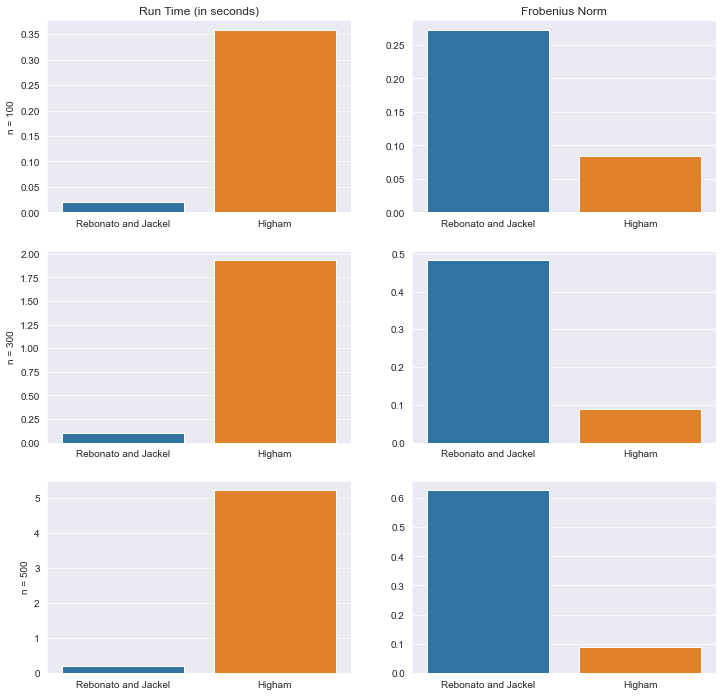

In [26]:
def a_non_psd_matrix(n):
    mat = np.matrix(np.full((n, n), 0.9), dtype='float64')
    np.fill_diagonal(mat, 1)
    mat[0, 1] = 0.7357  
    mat[1, 0] = 0.7357 
    return mat
    
sizes = [100, 300, 500]
fig, axes = plt.subplots(len(sizes), 2, figsize=(12, 4*len(sizes)))
for i, n in enumerate(sizes):
    sigma = a_non_psd_matrix(n)
    
    # generate results and run time
    near_time, near = run_time(near_psd, sigma)
    nearest_time, nearest = run_time(nearest_psd, sigma)
    
    # check results are PSD
    if not is_psd(near, 1e-6):
        print(f"near_psd does not produce a PSD matrix for n = {n}")
    if not is_psd(nearest, 1e-6):
        print(f"nearest_psd does not produce a PSD matrix for n = {n}")

    near_fnorm = frobenius_norm(near - sigma)
    nearest_fnorm = frobenius_norm(nearest - sigma)

    # plot run time and Frobenius Norm
    labels = ["Rebonato and Jackel", "Higham"]
    sns.barplot(x=labels, y=[near_time, nearest_time], ax=axes[i][0])
    sns.barplot(x=labels, y=[near_fnorm, nearest_fnorm], ax=axes[i][1])
    
    axes[i][0].set_ylabel(f"n = {n}")
    if i == 0:
        axes[i][0].set_title("Run Time (in seconds)")
        axes[i][1].set_title("Frobenius Norm")

# fig.savefig("fig2.jpeg")

# Problem 3

Using DailyReturn.csv.Implement a multivariate normal simulation that allows for simulation directly from a covariance matrix or using PCA with an optional parameter for % variance explained. If you have a library that can do these, you still need to implement it yourself for this homework and prove that it functions as expected.  

Generate a correlation matrix and variance vector 2 ways:
    1. Standard Pearson correlation/variance (you do not need to reimplement the cor() and var() functions).
    2. Exponentially weighted λ = 0. 97
    
Combine these to form 4 different covariance matrices.(Pearson correlation + var()), Pearson correlation + EW variance, etc.) Simulate 25,000 draws from each covariance matrix using:  
    1. Direct Simulation
    2. PCA with 100% explained.
    3. PCA with 75% explained.
    4. PCA with 50% explained.
Calculate the covariance of the simulated values. Compare the simulated covariance to it’s input matrix using the Frobenius Norm (L2 norm, sum of the square of the difference between the matrices). Compare the run times for each simulation.  
What can we say about the trade offs between time to run and accuracy?

In [27]:
def cal_std(cov):
    """Calculate the standard deviations with a covariance matrix."""
    return np.sqrt(np.diag(cov))

def cal_corr(cov):
    """Calculate the correlation matrix with a covariance matrix."""
    std = cal_std(cov)
    inversed_std = np.diag(1 / std)
    corr = inversed_std @ cov @ inversed_std
    return corr

def cal_cov(corr, std):
    """
    Calculate the covariance matrix with a correlation matrix 
    and a standard deviations array.
    """
    std = np.diag(std)
    return std @ corr @ std

In [28]:
class CholeskySimulator:
    
    def __init__(self, covariance):
        self.root = chol_psd(covariance)
    
    def simulate(self, nsample):
        return self.root @ scipy.random.randn(self.root.shape[1],nsample)
        

In [29]:
class PCASimulator:
    
    def __init__(self, sigma):
        self.pca = PCA(sigma)

    def factorize(self, explained, verbose):
        explained = min(explained, 1)
        
        # find the index of the minimum cumulative_evr 
        # that is greater than or equals to explained 
        # if explained = 1, this method will drop the eigen vectors
        # whose correspondent eigen value is close to 0
        idx = bisect_left(self.pca.cumulative_evr, explained) 
        eig_vals = self.pca.explained_variance[:idx+1]
        eig_vecs = self.pca.eig_vecs[:, :idx+1]
        if verbose:
            print(f"{self.pca.cumulative_evr[idx]*100:.2f}% total variance explained.\n" + 
                  f"{idx+1} eigen value(s) are used.")
        return eig_vecs @ np.diag(np.sqrt(eig_vals))
        
    def simulate(self, nsample, explained=1, verbose=False):
        L = self.factorize(explained, verbose)
        Z = scipy.random.randn(L.shape[1], nsample)
        return L @ Z


## 3.1 Comparing Efficiency and Accuracy

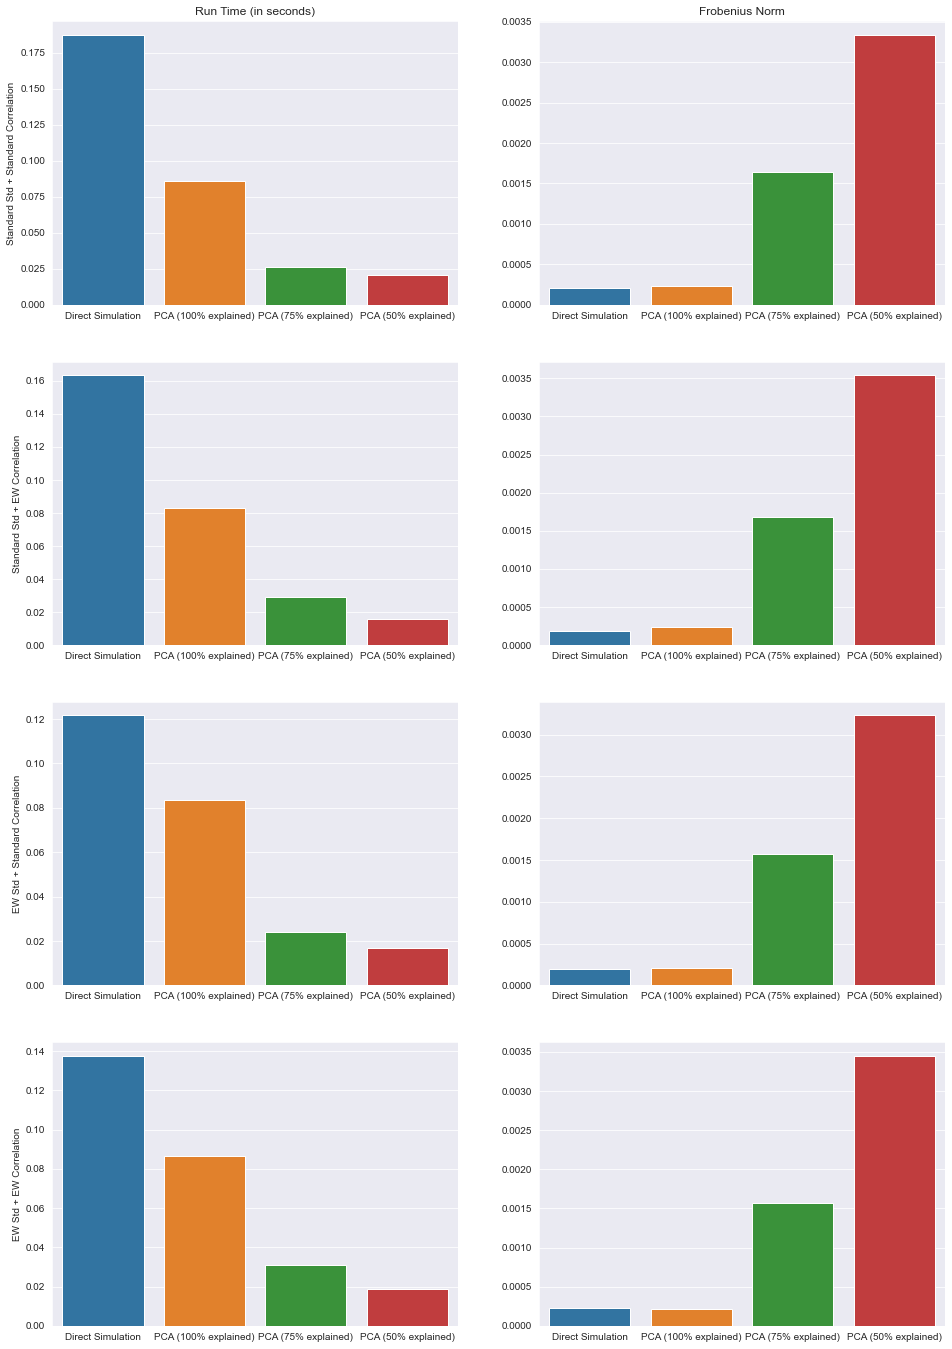

In [30]:
# import DailyReturn.csv in reversed the order to show recent data first, 
# drop the timestamp column, transpose it, then create a data matrix
daily_return = pd.read_csv("DailyReturn.csv").iloc[::-1, 1:].T
daily_return = np.matrix(daily_return)

std_cov = np.cov(daily_return)
std_std = cal_std(std_cov)
std_corr = cal_corr(std_cov)

ew_cov = cal_ewcov(daily_return, 0.97)
ew_std = cal_std(ew_cov)
ew_corr = cal_corr(ew_cov)

covs = [cal_cov(corr, std) for std in [std_std, ew_std] 
                           for corr in [std_corr, ew_corr]]

cov_labels = ["Standard Std + Standard Correlation", 
              "Standard Std + EW Correlation", 
              "EW Std + Standard Correlation", 
              "EW Std + EW Correlation"]


fig, axes = plt.subplots(len(covs), 2, figsize=(16,6*len(covs)))
for i, cov in enumerate(covs):
    chol_sim = CholeskySimulator(cov)
    pca_sim = PCASimulator(cov)
     
    times = []
    draws = []
    for simulate in [(chol_sim.simulate, 25000), (pca_sim.simulate, 25000, 1),
                     (pca_sim.simulate, 25000, 0.75), (pca_sim.simulate, 25000, 0.5)]:
        t, draw = run_time(*simulate)
        times.append(t)
        draws.append(draw)
        
    sim_labels = ["Direct Simulation", "PCA (100% explained)", "PCA (75% explained)", "PCA (50% explained)"]
    sns.barplot(x=sim_labels, y=times,ax=axes[i][0])
    axes[i][0].set_ylabel(cov_labels[i])

    f_norms = [frobenius_norm(np.cov(draw) - cov) for draw in draws]
    sns.barplot(x=sim_labels, y=f_norms, ax=axes[i][1])

    if i == 0:
        axes[i][0].set_title('Run Time (in seconds)')
        axes[i][1].set_title('Frobenius Norm')
# fig.savefig("fig3.jpeg")